In [1]:
import time
import math

import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import GridSearchCV

import pickle

In [2]:
extra_data=pd.read_csv('new_corrected_data-v1.csv')# loading extra genereated data genereated by LSTM #prediction_of_1_0007.csv
original_data=pd.read_csv('train_Data.csv')#original data

In [3]:
extra_data.head()#displaying LSTM generated data

,0,1,2,3,4,5,6,7,8,9,10
0,9.446130,265.878780,4566.4700,96.699875,0.531866,0.677844,-45.343613,1429.58390,2126.27270,172.42224,1.005978
1,-67.653885,25.818838,-1022.3427,70.825325,0.954398,1.156025,91.189600,-4571.55960,-5275.94780,-220.88791,1.009034
2,75.063430,76.774400,-30959.1300,11.029369,0.031528,0.386380,143.025620,-5387.82130,-7428.78000,-379.58694,1.069560
3,41.677856,17.654460,-3426.5596,21.878828,0.614289,0.771916,-36.663338,-855.75240,37.14639,50.53983,1.012424
4,2.611941,26.591124,-2916.9668,37.964504,0.716493,0.889433,16.892597,-700.36566,-600.96075,-20.57672,0.996902


In [4]:
extra=np.array(extra_data)# getting the original shape
print(extra.shape)

(146, 11)


In [5]:
extra[0] # showing first row vector

array([ 9.4461300e+00,  2.6587878e+02,  4.5664700e+03,  9.6699875e+01,
        5.3186566e-01,  6.7784400e-01, -4.5343613e+01,  1.4295839e+03,
        2.1262727e+03,  1.7242224e+02,  1.0059777e+00])

In [6]:
# Setting predictions of all generated data to 1 because their outputs are mostly 0.98, 0.99 etc. 
for i in range(0,len(extra),1):
    extra[i][8]=int(1)

In [7]:
extra #showing LSTM generated extra data ready for training

array([[ 9.4461300e+00,  2.6587878e+02,  4.5664700e+03, ...,
         1.0000000e+00,  1.7242224e+02,  1.0059777e+00],
       [-6.7653885e+01,  2.5818838e+01, -1.0223427e+03, ...,
         1.0000000e+00, -2.2088791e+02,  1.0090343e+00],
       [ 7.5063430e+01,  7.6774400e+01, -3.0959130e+04, ...,
         1.0000000e+00, -3.7958694e+02,  1.0695605e+00],
       ...,
       [ 5.2368060e+00,  9.7384870e+01,  1.1468146e+03, ...,
         1.0000000e+00,  7.1135315e+01,  1.0011657e+00],
       [ 5.6295616e+01, -5.9278374e+01,  4.1928066e+03, ...,
         1.0000000e+00,  2.0695506e+02,  1.0020413e+00],
       [ 1.5926976e+01,  6.0839756e+01,  2.5339060e+02, ...,
         1.0000000e+00,  6.4001280e+01,  9.9859040e-01]])

In [8]:
original_data.head() #showing original data

,0,1,2,3,4,5,6,7,8,9,10
0,10.0,16.0,160.0,1.600,0.338,0.888,2.08,54.0,142.0,26.0,0
1,8.0,8.0,64.0,1.000,0.484,1.000,3.44,31.0,64.0,9.0,0
2,10.0,18.0,180.0,1.800,0.572,0.867,6.44,103.0,156.0,16.0,0
3,5.0,18.0,90.0,3.600,0.322,1.000,1.45,29.0,90.0,20.0,0
4,9.0,96.0,864.0,10.667,0.281,0.815,1.96,243.0,704.0,124.0,0


In [9]:
#loading data values from original dataset(Pima)
val=original_data.values

In [10]:
X=val[:,:10].astype(float)# getting the feature values
Y=val[:,10].astype(int)# getting prediction

In [11]:
#extra_X denotes the extra training data generated by LSTM 
extra_X=extra[:,:10].astype(float)

#extra_Y denotes extra training prediction data for training the algorithm
extra_Y=extra[:,10].astype(int)

In [12]:
# extrain=original training data + LSTM generated training data

# eytrain=original training prediction + LSTM generated

extrain=np.concatenate((X,extra_X),axis=0)
eytrain=np.concatenate((Y,extra_Y),axis=0)

In [13]:
print(extrain.shape)
print(eytrain.shape)

(3976, 10)
(3976,)


In [14]:
test_Data=pd.read_csv('test_Data.csv')

In [15]:
test_Data=np.array(test_Data)

In [16]:
test_Data.shape

(1642, 11)

In [17]:
X_test=test_Data[:,:10].astype(float)
Y_test=test_Data[:,10].astype(int)

In [18]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.0001,0.001, 0.01, 0.1, 1, 10]
    gammas = [0.0001,0.001, 0.01, 0.1, 1,10]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf',probability=True), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_estimator_

In [20]:
# setting seed =7 to produce same results over and over again, it was maintained during different experiments 
seed=11


In [21]:
# first rbf_svc for training on just the original training data
#rbf_svc = SVC(kernel='rbf', gamma=0.00001, C=1000,probability=True).fit(X_train,Y_train)
rbf_svc=svc_param_selection(X,Y,5)

# secondly rbf_svc_extra for training on original+LSTM
rbf_svc_extra = svc_param_selection(extrain,eytrain,5)

In [22]:

# fitting the data
rbf_svc.fit(X,Y)
rbf_svc_extra.fit(extrain,eytrain)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [23]:
# loading the validation dataset previously set up by validation split(this data was not included in any training procedure)
Prediction_data=X_test

#producing the shape
Prediction_data.shape

(1642, 10)

In [24]:
# making predictions on validation dataset using svc trained only on original training data
prediction_on_real_dataset=rbf_svc.predict_proba(Prediction_data)

#saving probabilities
predictions=rbf_svc.predict(Prediction_data)

# making predictions on validation dataset using svc trained on original training data + LSTM generated data
prediction_on_real_dataset_adding_extra=rbf_svc_extra.predict_proba(Prediction_data)
#saving probabilities
predictions_extra=rbf_svc_extra.predict(Prediction_data)

In [25]:
print(len(prediction_on_real_dataset))

print(len(prediction_on_real_dataset_adding_extra))

1642
1642


In [26]:
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

from sklearn.metrics import roc_curve, roc_auc_score

In [27]:
f1_score(Y_test,predictions)#without_extra

0.7142857142857143

In [28]:
f1_score(Y_test,predictions_extra)#with_extra

0.7160493827160493

In [29]:
prediction_on_real_dataset[0]# probabilities of 2 class

array([0.98556492, 0.01443508])

In [30]:
# getting AUC score for classifier trained on only original data
fpr, tpr, thres=roc_curve(Y_test,prediction_on_real_dataset[:,1],pos_label=1)

#getting AUC score for classifier trained on original + LSTM generated data
efpr, etpr, ethres=roc_curve(Y_test,prediction_on_real_dataset_adding_extra[:,1],pos_label=1)

with_=auc(fpr,tpr)
without_=auc(efpr,etpr)
print('Without extra: ',auc(fpr,tpr))

print('With extra: ',auc(efpr,etpr))

Without extra:  0.9280744241856654
With extra:  0.9283103836811145


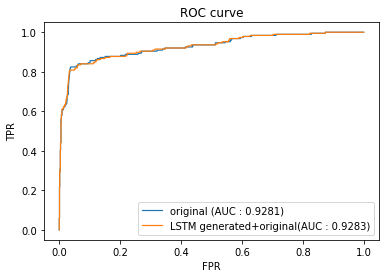

In [31]:
# plotting data ( for minority predictions , here minority class = 1)

Y_probs=prediction_on_real_dataset[:,1]
fpr,tpr,_=roc_curve(Y_test,Y_probs)

Y_probs_extra=prediction_on_real_dataset_adding_extra[:,1]
efpr,etpr,_=roc_curve(Y_test,Y_probs_extra)

original=auc(fpr,tpr)
lstm_with_extra=auc(efpr,etpr)

original=original.astype(float)
lstm_with_extra=lstm_with_extra.astype(float)


pyplot.clf()
pyplot.plot(fpr, tpr,label='original (AUC : %5.4f)'%(with_),linewidth='1.2')
pyplot.plot(efpr,etpr,label='LSTM generated+original(AUC : %5.4f)'%(without_),linewidth='1.2')
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
pyplot.title('ROC curve')
pyplot.legend(loc=4)
pyplot.savefig('ROC curve .png',dpi=500)
pyplot.show()